## Introduction to images

This notebook is a mismash of the following two links

- http://juliaimages.github.io/latest/arrays_colors.html
- https://evizero.github.io/Augmentor.jl/images/

with some of my own tests.

In [3]:
using Images
using FileIO
using TestImages

### Basics of Arrays in julia

In julia `Array` objects made of bit-types (such as `Float32`or `Uint8`) are stored as continuous block of memory. This is important for efficienty reasons. For example, selecting some elements from an `Array` `A`, for example  `A[i:i+10]`, can be much faster than selecting 10 random elements from different memory positions.


Blogs of memory can be "interpreted" in many ways. The function **`Base.reshape`** allow us to cast "vectors" to "matrices" of arbitrary dimensions (as long as the number of elements of the original `Array` matches the "reshaped" `Array`). Let's see an example

In [4]:
A = ["the", "tutorial", "helped", "me"]
B = [0x1, 0x2, 0x3, 0x4, 0x5, 0x6, 0x7, 0x8];

summary(A), summary(B)

("4-element Vector{String}", "8-element Vector{UInt8}")

Let us use `reshape` to give `B` a 2D structure. In this case we will make `B` of size `(4,2)`, that is  4 **rows** and 2 **columns**.


In [5]:
Bmat = reshape(B,(4,2))

4×2 Matrix{UInt8}:
 0x01  0x05
 0x02  0x06
 0x03  0x07
 0x04  0x08

The "reshaped" B is actually a convention that we make to, for example, facilitate programming. Nevertheless, `B` and `Bmat` refer to the same physical memory. We can use the function `pointer` from `Base` to see if `B` and `Bmat` start in the same memory position.

In [6]:
pointer(B), pointer(Bmat)

(Ptr{UInt8} @0x0000000154b93738, Ptr{UInt8} @0x0000000154b93738)

We could also view `B`  a 3D structure. This structure can have different sizes.

In [7]:
reshape(B, (2,2,2))

2×2×2 Array{UInt8, 3}:
[:, :, 1] =
 0x01  0x03
 0x02  0x04

[:, :, 2] =
 0x05  0x07
 0x06  0x08

In [8]:
reshape(B, (4,1,2))

4×1×2 Array{UInt8, 3}:
[:, :, 1] =
 0x01
 0x02
 0x03
 0x04

[:, :, 2] =
 0x05
 0x06
 0x07
 0x08

#### Vertical-Major vs Horizontal-Major

There are a number of different conventions for how to store image data into a binary format. The first question one has to address is the order in which the image dimensions are transcribed.

We have seen before that Julia follows the column-major convention for its arrays, which for images would lead to the corresponding convention of being vertical-major. In the image domain, however, it is fairly common to store the pixels in a horizontal-major layout. In other words, horizontal-major means that images are stored in memory (or file) one pixel row after the other.

In most cases, when working within the JuliaImages ecosystem, the images should already be in the Julia-native column major layout. If for some reason that is not the case there are two possible ways to convert the image to that format.

In [9]:
Bmat_trans = reshape(B, (4,2))' # "row-major" layout

2×4 adjoint(::Matrix{UInt8}) with eltype UInt8:
 0x01  0x02  0x03  0x04
 0x05  0x06  0x07  0x08

In [10]:
Bmat

4×2 Matrix{UInt8}:
 0x01  0x05
 0x02  0x06
 0x03  0x07
 0x04  0x08

The first way to alter the pixel order is by using the function **`Base.permutedims`**. In contrast to what we have seen before, this function will allocate a new array and copy the values in the appropriate manner.

The second way is using the function **`ImageCore.permuteddimsview`** which results in a lazy view that does not allocate a new array but instead only computes the correct values when queried.



In [11]:
Bmat_t      = permutedims(Bmat, (2,1))         # this is making a copy
Bmat_t_copy = permuteddimsview(Bmat, (2,1))    # this is not making a copy

2×4 PermutedDimsArray(::Matrix{UInt8}, (2, 1)) with eltype UInt8:
 0x01  0x02  0x03  0x04
 0x05  0x06  0x07  0x08

In [12]:
size(Bmat), size(Bmat_t)

((4, 2), (2, 4))

### Reinterpreting elements


Up to this point, all we talked about was how to resize or permuting the dimensional layout of some continuous memory block. If you look at the examples above you will see that all the arrays have elements of type `UInt8`, which just means that each element is represented by a single byte in memory.

Knowing all this, we can now take the idea a step further and think about reinterpreting the element types of the array. Let us consider the following vector `memory`.

In [13]:
memory = [0x1, 0x2, 0x3, 0x4, 0x5, 0x6]

6-element Vector{UInt8}:
 0x01
 0x02
 0x03
 0x04
 0x05
 0x06

Note how each byte is thought of as an individual element. One thing we could do instead, is think of this memory block as a vector of 3 UInt16 elements.

In [14]:
reinterpret(UInt16, memory)

3-element reinterpret(UInt16, ::Vector{UInt8}):
 0x0201
 0x0403
 0x0605

Pay attention to where our original bytes ended up. In contrast to just rearranging elements as we did before, we ended up with significantly different element values. One may ask why it would ever be practical to reinterpret a memory block like this. The one word answer to this is `Images.Colors` module.

As we will see in the remainder of this tutorial, it turns out to be a very useful thing to do when your arrays represent pixel data.



### Color Models

As we discussed before, there are a various number of conventions
on how to store pixel data into a binary format. That is not only
true for dimension priority, but also for color information.

One way color information can differ is in the [color
model](https://en.wikipedia.org/wiki/Color_model) in which they
are described in. Two famous examples for color models are *RGB*
and *HSV*. They essentially define how colors are conceptually
made up in terms of some components. Additionally, one can decide
on how many bits to use to describe each color component. By
doing so one defines the available [color
depth](https://en.wikipedia.org/wiki/Color_depth).

Before we look into using the actual implementation of Julia's
color models, let us prototype our own imperfect toy model in
order to get a better understanding of what is happening under
the hood.


In [17]:
# define our toy color model
struct MyRGB
    r::UInt8
    b::UInt8
    g::UInt8
end

In [18]:
fieldnames(MyRGB)

(:r, :b, :g)

Note how we defined our new toy color model as struct. Because of this and the fact that all its components are bit types (in this case UInt8), any instantiation of our new type will be represented as a continuous block of memory as well.

We can now apply our color model to our memory vector from above, and interpret the underlying memory as a vector of to MyRGB values instead.



In [19]:
reinterpret(MyRGB, memory)

2-element reinterpret(MyRGB, ::Vector{UInt8}):
 MyRGB(0x01, 0x02, 0x03)
 MyRGB(0x04, 0x05, 0x06)


Similar to the `UInt16` example, we now group neighboring bytes
into larger units (namely **`MyRGB`**). In contrast to the `UInt16`
example we are still able to access the individual components
underneath. This simple toy color model already allows us to do a
lot of useful things. We could define functions that work on
`MyRGB` values in a color-space appropriate fashion. We could
also define other color models and implement function to convert
between them.

However, our little toy color model is not yet optimal. For
example it hard-codes a predefined color depth of 24 bit. We may
have use-cases where we need a richer color space. One thing we
could do to achieve that would be to introduce a new type in
similar fashion. Still, because they have a different range of
available numbers per channel (because they have a different
amount of bits per channel), we would have to write a lot of
specialized code to be able to appropriately handle all color
models and depth.

Luckily, the creators of **`ColorTypes.jl`** went a with a more
generic strategy: Using parameterized types and **fixed point
numbers**.


If you are interested in how various color models are actually designed and/or implemented in Julia, you can take a look at the [ColorTypes.jl](https://github.com/JuliaGraphics/ColorTypes.jl) package.
    
    


## Fixed Point Numbers

The idea behind using fixed point numbers for each color
component is fairly simple. No matter how many bits a component
is made up of, we always want the largest possible value of the
component to be equal to `1.0` and the smallest possible value to
be equal to `0`. Of course, the amount of possible intermediate
numbers still depends on the number of underlying bits in the
memory, but that is not much of an issue.


In [22]:
using FixedPointNumbers
reinterpret(N0f8, 0xFF)

1.0N0f8

In [23]:
reinterpret(N0f16, 0xFFFF)

1.0N0f16


Not only does this allow for simple conversion between different
color depths, it also allows us to implement generic algorithms,
that are completely agnostic to the utilized color depth.

It is worth pointing out again, that we get all these goodies
without actually changing or copying the original memory block.
Remember how during this whole tutorial we have only changed the
interpretation of some underlying memory, and have not had the
need to copy any data so far.


For pixel data we are mainly interested in **unsigned** fixed  point numbers, but there are others too. Check out the package [FixedPointNumbers.jl](https://github.com/JuliaMath/FixedPointNumbers.jl) for more information on fixed point numbers in general.

Let us now leave our toy model behind and use the actual
implementation of `RGB` on our example vector `memory`. With the
first command we will interpret our data as two pixels with 8 bit
per color channel, and with the second command as a single pixel
of 16 bit per color channel


In [26]:
using Colors, FixedPointNumbers;
# Note how the values are now interpreted as floating point numbers.
summary(reinterpret(RGB{N0f8}, memory))

"2-element reinterpret(RGB{N0f8}, ::Vector{UInt8})"

In [27]:
summary(reinterpret(RGB{N0f16}, memory))

"1-element reinterpret(RGB{N0f16}, ::Vector{UInt8})"

### Casting images to standard Arrays 

- If we want to access the R,G,B channels of a colored image we can use the **`channelview`** function. That is 
    - ```img_3darray = Array{Float32}(channelview(img))```.
    
    

- If we want to cast a black and white image to Float 32 we can simply do 

    - `Float32.(Gray.(img))`

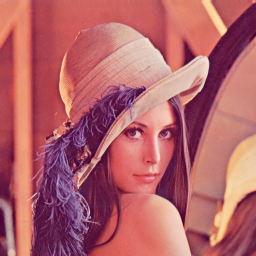

In [85]:
img = testimage("lena")

In [34]:
channelview(img)

3×256×256 reinterpret(reshape, N0f8, ::Array{RGB{N0f8},2}) with eltype N0f8:
[:, :, 1] =
 0.886  0.886  0.886  0.882  0.878  …  0.353  0.349  0.353  0.333  0.322
 0.537  0.537  0.541  0.522  0.506     0.098  0.094  0.11   0.078  0.086
 0.49   0.49   0.486  0.471  0.412     0.243  0.231  0.239  0.235  0.224

[:, :, 2] =
 0.875  0.875  0.875  0.878  0.875  …  0.392  0.376  0.357  0.357  0.369
 0.533  0.533  0.522  0.522  0.522     0.133  0.11   0.11   0.098  0.118
 0.51   0.51   0.475  0.439  0.439     0.251  0.239  0.239  0.231  0.243

[:, :, 3] =
 0.886  0.886  0.886  0.886  0.882  …  0.384  0.376  0.38   0.369  0.373
 0.522  0.522  0.525  0.522  0.51      0.118  0.114  0.114  0.102  0.098
 0.463  0.463  0.459  0.463  0.447     0.255  0.247  0.247  0.243  0.239

;;; … 

[:, :, 254] =
 0.902  0.902  0.871  0.612  0.392  …  0.412  0.486  0.549  0.6    0.655
 0.569  0.569  0.522  0.271  0.106     0.122  0.165  0.208  0.251  0.278
 0.498  0.498  0.463  0.329  0.251     0.235  0.271  0.278 

In [35]:
Array{Float32}(channelview(img))

3×256×256 Array{Float32, 3}:
[:, :, 1] =
 0.886275  0.886275  0.886275  0.882353  …  0.352941  0.333333   0.321569
 0.537255  0.537255  0.541176  0.521569     0.109804  0.0784314  0.0862745
 0.490196  0.490196  0.486275  0.470588     0.239216  0.235294   0.223529

[:, :, 2] =
 0.87451   0.87451   0.87451   0.878431  …  0.356863  0.356863   0.368627
 0.533333  0.533333  0.521569  0.521569     0.109804  0.0980392  0.117647
 0.509804  0.509804  0.47451   0.439216     0.239216  0.231373   0.243137

[:, :, 3] =
 0.886275  0.886275  0.886275  0.886275  …  0.380392  0.368627  0.372549
 0.521569  0.521569  0.52549   0.521569     0.113725  0.101961  0.0980392
 0.462745  0.462745  0.458824  0.462745     0.247059  0.243137  0.239216

;;; … 

[:, :, 254] =
 0.901961  0.901961  0.870588  0.611765  …  0.54902   0.6       0.654902
 0.568627  0.568627  0.521569  0.270588     0.207843  0.25098   0.278431
 0.498039  0.498039  0.462745  0.329412     0.278431  0.321569  0.329412

[:, :, 255] =
 0.909804  


Notice that we cannot convert a color image to a 3D array directly using 
`Array{Float32}(img)`.


In [36]:
# This will not work
Array{Float32}(img)

LoadError: MethodError: [0mCannot `convert` an object of type [92mRGB{N0f8}[39m[0m to an object of type [91mFloat32[39m
[0mClosest candidates are:
[0m  convert(::Type{T}, [91m::Base.TwicePrecision[39m) where T<:Number at twiceprecision.jl:273
[0m  convert(::Type{T}, [91m::AbstractChar[39m) where T<:Number at char.jl:185
[0m  convert(::Type{T}, [91m::CartesianIndex{1}[39m) where T<:Number at multidimensional.jl:130
[0m  ...

In [521]:
img_channels = channelview(img);
println(summary(img_channels))

img_channels_float32 = Array{Float32}(img_channels)
println(summary(img_channels_float32))

3×256×256 reinterpret(reshape, N0f8, ::Array{RGB{N0f8},2}) with eltype N0f8
3×256×256 Array{Float32, 3}


#### Cast image to Array if `UInt8` values

In [523]:
rawview(channelview(img))

3×256×256 rawview(reinterpret(reshape, N0f8, ::Array{RGB{N0f8},2})) with eltype UInt8:
[:, :, 1] =
 0xe2  0xe2  0xe2  0xe1  0xe0  0xdf  …  0x5e  0x5a  0x59  0x5a  0x55  0x52
 0x89  0x89  0x8a  0x85  0x81  0x83     0x1a  0x19  0x18  0x1c  0x14  0x16
 0x7d  0x7d  0x7c  0x78  0x69  0x6c     0x3d  0x3e  0x3b  0x3d  0x3c  0x39

[:, :, 2] =
 0xdf  0xdf  0xdf  0xe0  0xdf  0xdf  …  0x62  0x64  0x60  0x5b  0x5b  0x5e
 0x88  0x88  0x85  0x85  0x85  0x85     0x20  0x22  0x1c  0x1c  0x19  0x1e
 0x82  0x82  0x79  0x70  0x70  0x6e     0x42  0x40  0x3d  0x3d  0x3b  0x3e

[:, :, 3] =
 0xe2  0xe2  0xe2  0xe2  0xe1  0xe3  …  0x64  0x62  0x60  0x61  0x5e  0x5f
 0x85  0x85  0x86  0x85  0x82  0x82     0x1e  0x1e  0x1d  0x1d  0x1a  0x19
 0x76  0x76  0x75  0x76  0x72  0x69     0x42  0x41  0x3f  0x3f  0x3e  0x3d

;;; … 

[:, :, 254] =
 0xe6  0xe6  0xde  0x9c  0x64  0x5c  …  0x66  0x69  0x7c  0x8c  0x99  0xa7
 0x91  0x91  0x85  0x45  0x1b  0x15     0x1d  0x1f  0x2a  0x35  0x40  0x47
 0x7f  0x7f  0x76  0x54  0x


#### Resize image

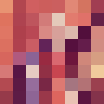

In [305]:
img = testimage("lena");
img_resized = imresize(img, 8, 8)

In [349]:
img_resized_channels = channelview(img_resized);
size(img_resized_channels)

(3, 8, 8)

#### Image hash

In [369]:
img_resized_gray = Gray.(img_resized)
mean_image = mean((Gray.(img_resized)));
mean_image.val

0.4730392156862745

In [508]:
aux = img_resized_gray .< mean_image

8×8 BitMatrix:
 0  1  0  0  0  0  0  1
 0  1  1  0  0  0  0  1
 0  1  1  0  0  0  1  0
 0  1  0  1  0  1  1  0
 0  1  1  1  0  1  0  0
 0  1  0  1  1  1  0  0
 1  1  0  1  0  0  0  1
 1  1  1  1  0  0  1  1

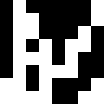

In [401]:
Gray.(aux)

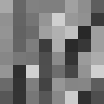

In [519]:
img_resized_gray

In [518]:
img = testimage("lena");
reinterpret(img, Matrix{RGB{UInt8}})

LoadError: TypeError: in RGB, in T, expected T<:Union{AbstractFloat, FixedPoint}, got Type{UInt8}

We can reinterpret a `UInt8` as `N0f8`

In [431]:
n0f8 = reinterpret(N0f8, UInt8(2))

0.008N0f8

We can also do the oposite  `UInt8` as `N0f8`

In [432]:
reinterpret(UInt8,n0f8)

0x02

We can do the same process with matrices

In [462]:
img = testimage("barbara_color.png");
println(size(img))
img_uint8 = reinterpret(UInt8, img)
println(size(img_uint8))

(576, 720)
(1728, 720)


In [498]:
img = testimage("barbara_color.png");
println(size(img))
img_uint8 = reinterpret(UInt8, img)
img_uint8 = reshape(img_uint8, (3,576,720));

(576, 720)


In [ ]:
reshape(img_uint8, (3,576,720))

In [504]:
img = testimage("barbara_color.png");
X = reshape( reinterpret(UInt8, img), (3,size(img)...))

3×576×720 reshape(reinterpret(UInt8, ::Array{RGB{N0f8},2}), 3, 576, 720) with eltype UInt8:
[:, :, 1] =
 0x09  0x09  0x0b  0x0b  0x09  0x09  …  0x09  0x09  0x09  0x08  0x09  0x09
 0x11  0x11  0x11  0x11  0x11  0x12     0x11  0x11  0x12  0x11  0x12  0x11
 0x0c  0x0a  0x08  0x08  0x0a  0x08     0x0a  0x0a  0x08  0x07  0x08  0x0a

[:, :, 2] =
 0x09  0x09  0x0b  0x0b  0x09  0x09  …  0x09  0x09  0x09  0x09  0x09  0x09
 0x11  0x11  0x11  0x11  0x11  0x12     0x11  0x11  0x12  0x12  0x12  0x11
 0x0c  0x0a  0x08  0x08  0x0a  0x08     0x0a  0x0a  0x08  0x08  0x08  0x0a

[:, :, 3] =
 0x09  0x09  0x0b  0x0b  0x0b  0x09  …  0x09  0x09  0x0b  0x0b  0x08  0x09
 0x11  0x11  0x11  0x10  0x10  0x11     0x11  0x12  0x10  0x10  0x10  0x11
 0x0a  0x0a  0x08  0x0a  0x0a  0x0a     0x0a  0x08  0x0a  0x0a  0x09  0x0a

;;; … 

[:, :, 718] =
 0x0a  0x0b  0x0a  0x08  0x0a  0x0a  …  0x0b  0x09  0x0b  0x0b  0x09  0x09
 0x0f  0x10  0x0f  0x10  0x0f  0x10     0x10  0x11  0x11  0x11  0x11  0x11
 0x09  0x0a  0x0b  0x0

In [497]:
img_ = reshape(img_uint8, (3,576,720))

3×576×720 reshape(reinterpret(UInt8, ::Array{RGB{N0f8},2}), 3, 576, 720) with eltype UInt8:
[:, :, 1] =
 0x09  0x09  0x0b  0x0b  0x09  0x09  …  0x09  0x09  0x09  0x08  0x09  0x09
 0x11  0x11  0x11  0x11  0x11  0x12     0x11  0x11  0x12  0x11  0x12  0x11
 0x0c  0x0a  0x08  0x08  0x0a  0x08     0x0a  0x0a  0x08  0x07  0x08  0x0a

[:, :, 2] =
 0x09  0x09  0x0b  0x0b  0x09  0x09  …  0x09  0x09  0x09  0x09  0x09  0x09
 0x11  0x11  0x11  0x11  0x11  0x12     0x11  0x11  0x12  0x12  0x12  0x11
 0x0c  0x0a  0x08  0x08  0x0a  0x08     0x0a  0x0a  0x08  0x08  0x08  0x0a

[:, :, 3] =
 0x09  0x09  0x0b  0x0b  0x0b  0x09  …  0x09  0x09  0x0b  0x0b  0x08  0x09
 0x11  0x11  0x11  0x10  0x10  0x11     0x11  0x12  0x10  0x10  0x10  0x11
 0x0a  0x0a  0x08  0x0a  0x0a  0x0a     0x0a  0x08  0x0a  0x0a  0x09  0x0a

;;; … 

[:, :, 718] =
 0x0a  0x0b  0x0a  0x08  0x0a  0x0a  …  0x0b  0x09  0x0b  0x0b  0x09  0x09
 0x0f  0x10  0x0f  0x10  0x0f  0x10     0x10  0x11  0x11  0x11  0x11  0x11
 0x09  0x0a  0x0b  0x0

Note that here each triplet of values in each coordinate is the same as the RGB channels form the original image

In [496]:
Int.(img_[1:end,1,1])

3-element Vector{Int64}:
  9
 17
 12

In [507]:
255 * [img[1].r, img[1].g, img[1].b]

3-element Vector{Float32}:
  9.0
 17.0
 12.0

In [446]:
size(img)

(256, 256)

In [520]:
#reinterpret(img, Matrix{UInt8})

In [ ]:
mean_image.val

In [344]:
x = UInt8.(255*img_resized_channels);

In [347]:
x[1:3,1,1]

3-element Vector{UInt8}:
 0xe8
 0x93
 0x72

We can iterate over columns of the image and average every 3 values

In [339]:
for (k,a) in enumerate(x)
    println(k, "-->" ,a)
end

1-->232
2-->147
3-->114
4-->223
5-->115
6-->94
7-->224
8-->118
9-->100
10-->220
11-->112
12-->96
13-->215
14-->102
15-->93
16-->214
17-->121
18-->119
19-->179
20-->74
21-->81
22-->150
23-->58
24-->74
25-->177
26-->70
27-->79
28-->174
29-->67
30-->80
31-->174
32-->64
33-->76
34-->176
35-->65
36-->78
37-->176
38-->90
39-->127
40-->88
41-->22
42-->69
43-->92
44-->26
45-->68
46-->93
47-->28
48-->70
49-->208
50-->95
51-->96
52-->190
53-->85
54-->93
55-->185
56-->72
57-->84
58-->202
59-->93
60-->100
61-->139
62-->99
63-->149
64-->230
65-->202
66-->194
67-->150
68-->109
69-->156
70-->142
71-->101
72-->149
73-->204
74-->94
75-->92
76-->210
77-->123
78-->121
79-->217
80-->137
81-->132
82-->98
83-->35
84-->88
85-->153
86-->42
87-->65
88-->145
89-->48
90-->69
91-->121
92-->39
93-->69
94-->154
95-->56
96-->74
97-->203
98-->95
99-->95
100-->228
101-->201
102-->186
103-->215
104-->160
105-->154
106-->207
107-->159
108-->152
109-->217
110-->104
111-->112
112-->200
113-->69
114-->80
115-->222
116-->12

In [261]:
img = testimage("lena");
img_resized = imresize(img, 8, 8)
img_resized_channels = channelview(img_resized);
eltype(img_resized_channels)

N0f8 (alias for Normed{UInt8, 8})

In [271]:
@benchmark UInt8.(255*img_resized_channels)

BenchmarkTools.Trial: 10000 samples with 110 evaluations.
 Range (min … max):  772.727 ns … 52.073 μs  ┊ GC (min … max): 0.00% … 97.87%
 Time  (median):     834.091 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   887.822 ns ±  1.763 μs  ┊ GC (mean ± σ):  7.12% ±  3.53%

      ▄█▂                                                       
  ▁▂▄████▆▂▁▁▁▁▁▂▂▁▁▁▁▁▂▃▄▅██▇▅▆▅▄▄▄▄▃▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  773 ns          Histogram: frequency by time          922 ns <

 Memory estimate: 1.22 KiB, allocs estimate: 5.

In [232]:
img = testimage("cameraman.tif");
img_resized = imresize(img, 8, 8)
img_resized_channels = channelview(img_resized);
eltype(img_resized_channels)

N0f8 (alias for Normed{UInt8, 8})

In [259]:
img_resized_channels[4]

0.0N0f8

In [252]:
img_resized_channels

8×8 reinterpret(reshape, N0f8, ::Array{Gray{N0f8},2}) with eltype N0f8:
 0.635  0.667  0.69   0.702  0.702  0.671  0.663  0.62
 0.647  0.69   0.702  0.043  0.706  0.682  0.639  0.596
 0.663  0.698  0.051  0.047  0.557  0.659  0.635  0.588
 0.643  0.043  0.047  0.047  0.035  0.635  0.62   0.584
 0.639  0.047  0.047  0.647  0.639  0.667  0.62   0.596
 0.404  0.047  0.063  0.369  0.408  0.447  0.533  0.502
 0.49   0.039  0.055  0.769  0.573  0.533  0.455  0.514
 0.467  0.149  0.082  0.525  0.451  0.494  0.427  0.427

In [201]:
float32(img_resized_channels[1])

0.9098039f0

In [217]:
RGB(0.3,0.5,0.9)

In [220]:
RGB(UInt8(23),UInt8(23),UInt8(23))

LoadError: ArgumentError: (0x17, 0x17, 0x17) are integers in the range 0-255, but integer inputs are encoded with the N0f8
  type, an 8-bit type representing 256 discrete values between 0 and 1.
  Consider dividing your input values by 255, for example: RGB{N0f8}(23/255,23/255,23/255)
  Or use `reinterpret(N0f8, x)` if `x` is a `UInt8`.
  See the READMEs for FixedPointNumbers and ColorTypes for more information.

In [164]:
img = testimage("lena");
img_resized = imresize(img, 8, 8)
img_resized_channels = channelview(img_resized);
size(img_resized_channels)

(3, 8, 8)

In [169]:
function mean_over_channels(im_channel_view)
    result = zeros(UInt8, 64)
    for (i,x) in enumerate(im_channel_view)
        result[i] +=x
    end
    return result
end

mean_over_channels (generic function with 1 method)

In [174]:
dump(img)

Array{RGB{N0f8}}((256, 256))
  1: RGB{N0f8}
    r: N0f8
      i: UInt8 0xe2
    g: N0f8
      i: UInt8 0x89
    b: N0f8
      i: UInt8 0x7d
  2: RGB{N0f8}
    r: N0f8
      i: UInt8 0xe2
    g: N0f8
      i: UInt8 0x89
    b: N0f8
      i: UInt8 0x7d
  3: RGB{N0f8}
    r: N0f8
      i: UInt8 0xe2
    g: N0f8
      i: UInt8 0x8a
    b: N0f8
      i: UInt8 0x7c
  4: RGB{N0f8}
    r: N0f8
      i: UInt8 0xe1
    g: N0f8
      i: UInt8 0x85
    b: N0f8
      i: UInt8 0x78
  5: RGB{N0f8}
    r: N0f8
      i: UInt8 0xe0
    g: N0f8
      i: UInt8 0x81
    b: N0f8
      i: UInt8 0x69
  ...
  65532: RGB{N0f8}
    r: N0f8
      i: UInt8 0x8c
    g: N0f8
      i: UInt8 0x32
    b: N0f8
      i: UInt8 0x48
  65533: RGB{N0f8}
    r: N0f8
      i: UInt8 0x99
    g: N0f8
      i: UInt8 0x38
    b: N0f8
      i: UInt8 0x49
  65534: RGB{N0f8}
    r: N0f8
      i: UInt8 0xa1
    g: N0f8
      i: UInt8 0x3b
    b: N0f8
      i: UInt8 0x4a
  65535: RGB{N0f8}
    r: N0f8
      i: UInt8 0xaa
    g: N0f8
  

#### From color image to black and white

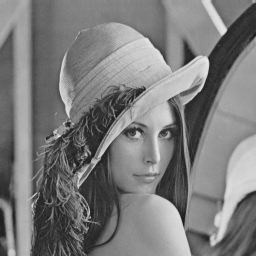

In [38]:
lenagray = Array{ColorTypes.Gray{Float32},2}(img)

Another way to get a black and white image is to simply compute the mean over all chanels at each position in the image 

In [171]:
using Statistics

In [172]:
lenagray2 = reshape(mean(channelview(img),dims=1),size(img));

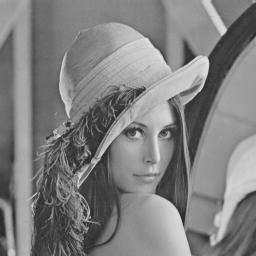

In [173]:
Array{Gray}(lenagray2)

## Displaying, loading and plotting images

Any array can be treated as an Image. In graphical environments, only arrays with Colorant element types (Gray, RGB, ARGB, etc.) are automatically displayed as images.


Images are a subtype of AbstractArray. Let us load an image from `TestImages`

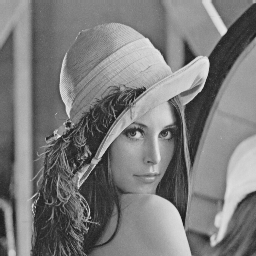

In [107]:
img = testimage("lena_gray")

There are some functions that give us information about the image:

- `typeof(img)`: give us that the `type` of an image and we can see it is an `Array`.


- `summary(img)`: give us the size of the array and the `type` of the elements inside the array.


A list of methods from the package can be found here: 

- http://juliaimages.github.io/latest/function_reference.html

In [108]:
typeof(img)

Array{Gray{Normed{UInt8,8}},2}

In [109]:
summary(img)

"256×256 Array{Gray{N0f8},2} with eltype Gray{Normed{UInt8,8}}"

In [110]:
supertype(ColorTypes.Gray)

Color{T,1} where T<:Union{Bool, AbstractFloat, FixedPoint}

### Slices of an image

In `Images`, images are just Arrays with an special type of element.
the slice of `Array{ColorTypes.Gray{FixedPointNumbers.Normed{UInt8,8}},2}` is a copy of the original array.

That means that if we change the slice the original image is not affected

In [137]:
img = testimage("lena_gray");

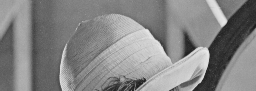

In [138]:
img[10:100,:]

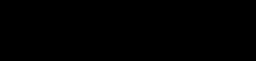

In [139]:
img[40:100,:] .= Int64(0)

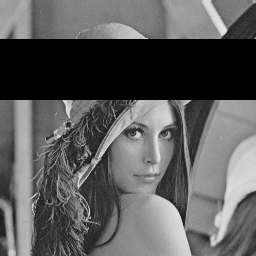

In [140]:
img

This explains a core abstraction: one array element = one pixel. In other languages (Matlab, Python) where you don't have this, you have to make guesses about whether this 3d array is a color image or an actual 3d volume (think biomedical imaging). That makes for some pretty horrifying code that occasionally does the wrong thing when your heuristics for guessing fail

#### Views of an image


In [147]:
img = rand(640,480)               # a random Float64 image
img = rand(RGB{N0f8}, 256, 256)   # a random RGB image, 8 bits per channel

# select a region-of-interest from a larger image
imgc = img[200:245, 17:42]        # makes a copy
imgv = @view img[200:245, 17:42]  # makes a view
imgv = view(img,200:245, 17:42)   # makes a view, does the same as the previous line

# an image that starts black in the upper left and gets bright in the lower right:
img = reshape(range(0, stop=1, length=10^4), 100, 100)


# a 3d box image
img = zeros(128, 128, 80)
img[20:100, 20:100, 10:70] .= 1;

Some add-on packages enable additional behavior. For example,



In [153]:
using Images, Unitful, AxisArrays
using Unitful: mm, s

img = AxisArray(rand(256, 256, 100, 50),
               (:x, :y, :z, :time),
               (0.4mm, 0.4mm, 1mm, 2s));

defines a 4d image (3 space dimensions plus one time dimension) with the specified name and physical pixel spacing for each coordinate. The AxisArrays package supports rich and efficient operations on such arrays, and can be useful to keep track of not just pixel spacing but the orientation convention used for multidimensional images.

JuliaImages interoperates smoothly with AxisArrays and many other packages. As further examples,


- the `ImageMetadata` package (incorporated into Images itself) allows you to "tag" images with custom metadata


- the `IndirectArrays` package supports indexed (colormap) images


- the `MappedArrays` package allows you to represent lazy value-transformations, facilitating work with images that may be too large to store in memory at oncthe MappedArrays package allows you to represent lazy value-transformations, facilitating work with images that may be too large to store in memory at once


- `ImageTransformations` allows you to encode rotations, shears, deformations, etc., either eagerly or lazilImageTransformations allows you to encode rotations, shears, deformations, etc., either eagerly or lazil-y

It is very easy to define new array types in Julia–and consequently specialized images or operations–and have them interoperate smoothly with the vast majority of functions in JuliaImages.



## Colors, the 0-to-1 intensity scale, and views


In JuliaImages, **by default all images are displayed assuming that 0 means "black" and 1 means "white" or "saturated"** (the latter applying to channels of an RGB image). 

Perhaps surprisingly, **the 0-to-1 convention applies even when the intensities are encoded using only 8-bits per color channel**. 

**JuliaImages uses a special type, N0f8, that interprets an 8-bit "integer" as if it had been scaled by 1/255, thus encoding values from 0 to 1 in 256 steps**. N0f8 numbers (standing for Normalized, with 0 integer bits and 8 fractional bits) obey standard mathematical rules, and can be added, multiplied, etc. There are types like N0f16 for working with 16-bit images (and even N2f14 for images acquired with a 14-bit camera, etc.).

This infrastructure allows us to unify "integer" and floating-point images, and avoids the need for special conversion functions that change the value of pixels when your main goal is simply to change the type (numeric precision and properties) used to represent the pixel.

Because images are just arrays, some environments (e.g., IJulia/Jupyter) will display numeric arrays as arrays (using a text representation) but will display 2d arrays that have Colorant elements as images. You can "convert" in the following ways:



In [154]:
img1 = colorview(Gray, rand(8, 8))           # encodes as Gray{Float64}, so displays as image
img2 = colorview(RGB, rand(3, 8, 8))         # encodes as a 2d RGB{Float64} array
img3 = colorview(RGB, rand(N0f8, 3, 8, 8));  # uses only 8 bits per channel

**All of these "conversions" actually create views, meaning that no copies of the underlying storage are made unless you call copy on the result.**

Base.ReinterpretArray{Gray{Float64},2,Float64,Array{Float64,2}}


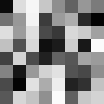

In [155]:
println(typeof(img1))
img1

Base.ReshapedArray{RGB{Float64},2,Base.ReinterpretArray{RGB{Float64},3,Float64,Array{Float64,3}},Tuple{}}


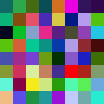

In [156]:
println(typeof(img2))
img2

Base.ReshapedArray{RGB{Normed{UInt8,8}},2,Base.ReinterpretArray{RGB{Normed{UInt8,8}},3,Normed{UInt8,8},Base.ReinterpretArray{Normed{UInt8,8},3,UInt8,Array{UInt8,3}}},Tuple{}}


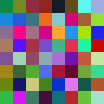

In [157]:
println(typeof(img3))
img3

In [158]:
# The following two "convert" between representation as an 8-bit RGB
# image and as a 3×m×n UInt8 array
#img = colorview(RGB, normedview(img1))
#A = rawview(channelview(rand(RGB{N0f8}, 8, 8)))

## Default orientation and storage order


Images are **"vertical-major"**, meaning that when the image is displayed the first index corresponds to the vertical axis. Note that by default, in Julia the first index is also the fastest (i.e., has adjacent storage in memory).

You can use **`permuteddimsview`** to "reinterpret" the orientation of a
chunk of memory without making a copy, or **`permutedims`** if you want a
copy.


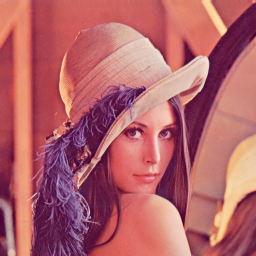

In [159]:
img = testimage("lena")

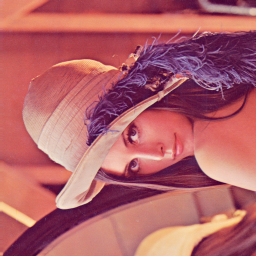

In [160]:
permuteddimsview(img,[2,1])


## Arrays with arbitrary indices

If you have an input image and perform some kind of spatial
transformation on it, how do pixels/voxels in the transformed image
match up to pixels in the input? Through Julia's support for arrays
with indices that start at values other than 1, it is possible to
allow array indices to represent *absolute* position in space, making
it straightforward to keep track of the correspondence between
location across multiple images. More information can be found in
[Keeping track of location with unconventional indices](@ref).

## Function categories

See [Summary and function reference](@ref) for more information about
each of the topics below. The list below is accessible via `?Images`
from the Julia REPL. If you've used other frameworks previously, you
may also be interested in the
[Comparison with other image processing frameworks](@ref).

#### Constructors, conversions, and traits:

- Construction: use constructors of specialized packages, e.g., `AxisArray`, `ImageMeta`, etc.
- "Conversion": `colorview`, `channelview`, `rawview`, `normedview`, `permuteddimsview`, `paddedviews`
- Traits: `pixelspacing`, `sdims`, `timeaxis`, `timedim`, `spacedirections`

#### Contrast/coloration:

- `clamp01`, `clamp01nan`, `scaleminmax`, `colorsigned`, `scalesigned`

#### Algorithms:

- Reductions: `maxfinite`, `maxabsfinite`, `minfinite`, `meanfinite`, `sad`, `ssd`, `integral_image`, `boxdiff`, `gaussian_pyramid`


- Resizing and spatial transformations: `restrict`, `imresize`, `warp`


- Filtering: `imfilter`, `imfilter!`, `imfilter_LoG`, `mapwindow`, `imROF`, `padarray`


- Filtering kernels: `Kernel.` or `KernelFactors.`, followed by `ando[345]`, `guassian2d`, `imaverage`, `imdog`, `imlaplacian`, `prewitt`, `sobel`


- Exposure : `imhist`, `histeq`, `adjust_gamma`, `histmatch`, `imadjustintensity`, `imstretch`, `imcomplement`, `clahe`, `cliphist`


- Gradients: `backdiffx`, `backdiffy`, `forwarddiffx`, `forwarddiffy`, `imgradients`


- Edge detection: `imedge`, `imgradients`, `thin_edges`, `magnitude`, `phase`, `magnitudephase`, `orientation`, `canny`


- Corner detection: `imcorner`, `harris`, `shi_tomasi`, `kitchen_rosenfeld`, `meancovs`, `gammacovs`, `fastcorners`


- Blob detection: `blob_LoG`, `findlocalmaxima`, `findlocalminima`


- Morphological operations: `dilate`, `erode`, `closing`, `opening`, `tophat`, `bothat`, `morphogradient`, `morpholaplace`, `feature_transform`, `distance_transform`


- Connected components: `label_components`, `component_boxes`, `component_lengths`, `component_indices`, `component_subscripts`, `component_centroids`


- Interpolation: `bilinear_interpolation`

Test images and phantoms (see also TestImages.jl):

- `shepp_logan`